In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolorsx
from matplotlib.patches import Circle

import os

from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.nddata import Cutout2D

from reproject import reproject_exact

from AstroColour.AstroColour import RGB

import matplotlib.patheffects as patheffects

%matplotlib widget

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig_width_pt = 244.0  # Get this from LaTeX using \the\columnwidth
text_width_pt = 508.0 # Get this from LaTeX using \the\textwidth

# plt.rc('font', size=21)
# plt.rc('xtick', labelsize=21)
# plt.rc('ytick', labelsize=21)

inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt*1.5 # width in inches
fig_width_full = text_width_pt*inches_per_pt  # 17

In [3]:
obj = pd.read_csv('/Users/zgl12/Modules/SN2019vxm/Data/ps1_galaxy.csv')

In [5]:
atclean_folder = '../../Data/'

coords = pd.read_csv('/Users/zgl12/Modules/SN2019vxm/Data/2019vxm_control_coords.txt', delim_whitespace=True)

coords

,tnsname,control_index,ra,dec,ra_offset,dec_offset,radius_arcsec,n_detec,n_detec_o,n_detec_c
0,2019vxm,0,299.618917,62.137731,NaN,NaN,16.882449,3237,2540,697
1,NaN,2,299.610982,62.139550,0.000000,0.004690,16.882449,3240,2543,697
2,NaN,3,299.603887,62.138176,-0.007095,0.003316,16.882449,3237,2542,695
3,NaN,4,299.600948,62.134860,-0.010033,0.000000,16.882449,3233,2539,694
4,NaN,5,299.603887,62.131544,-0.007095,-0.003316,16.882449,3229,2534,695
5,NaN,6,299.610982,62.130171,-0.000000,-0.004690,16.882449,3229,2533,696
6,NaN,7,299.618076,62.131544,0.007095,-0.003316,16.882449,3230,2534,696
7,NaN,8,299.621015,62.134860,0.010033,-0.000000,16.882449,3236,2537,699


In [8]:
fits_folder = '/Users/zgl12/Research/ATClean_FITS/'

g_fits_file = fits_folder+'rings.v3.skycell.2491.050.stk.g.unconv.fits'
r_fits_file = fits_folder+'rings.v3.skycell.2491.050.stk.r.unconv.fits'
i_fits_file = fits_folder+'rings.v3.skycell.2491.050.stk.i.unconv.fits'

hdul = fits.open(g_fits_file)
wcs = WCS(hdul[1].header)
g_data = hdul[1].data
hdul.close()

hdul = fits.open(r_fits_file)
r_data = hdul[1].data
hdul.close()

hdul = fits.open(i_fits_file)
i_data = hdul[1].data
hdul.close()

cdelt_x = wcs.wcs.cdelt[0]  # scale in RA (degrees per pixel)
cdelt_y = wcs.wcs.cdelt[1]  # scale in Dec (degrees per pixel)

cdelt_x_arcsec = cdelt_x * 3600  # arcseconds per pixel in RA
cdelt_y_arcsec = cdelt_y * 3600  # arcseconds per pixel in Dec
pixel_scale = np.nanmean([cdelt_x_arcsec, cdelt_y_arcsec])


pixel_distance = coords['radius_arcsec'].values / pixel_scale

x, y = wcs.all_world2pix(coords['ra'].values, coords['dec'].values, 0)

x_cen = 4740.9189

y_cen = 2859.1121

colour_images = []

for i in [g_data, r_data, i_data]:
    colour_images.append(i)

In [14]:
rgb = RGB(colour_images, 
          save = False, save_name = 'sn2025ngs', save_folder = '/Users/zgl12/', 
          epsf_plot=False, epsf = True,
          bkg_plot = False, temp_save = True, run = False, manual_override=35)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.5911104869517594].


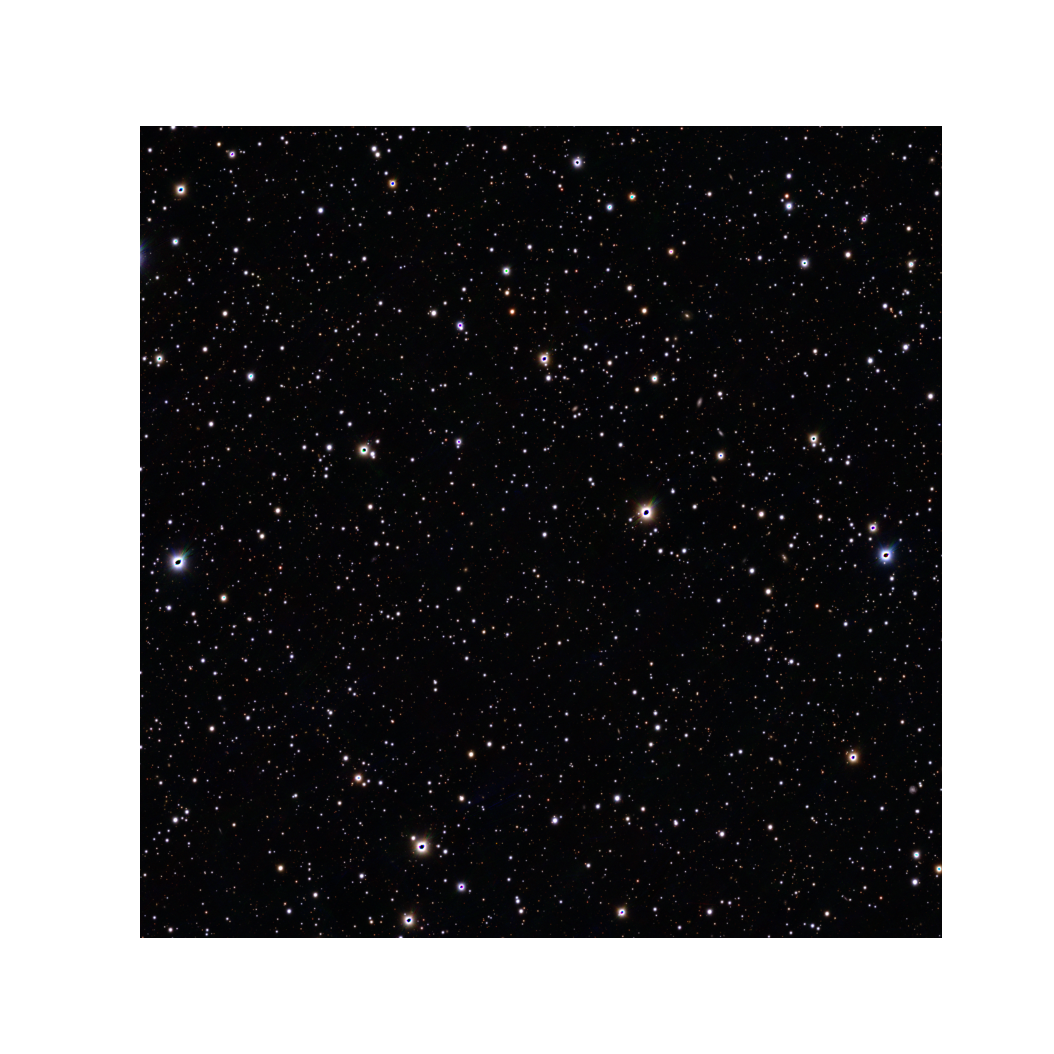

In [20]:
colour = rgb.master_plot(colour_images, 
                         colours = ['blue', 'green', 'red'], 
                         intensities = [0.57, 1, 0.57], 
                         gamma = [1.5, 1.5, 1.5],
                         norms = ['linear', 'linear', 'linear',], 
                         uppers = [99, 99, 99,],
                         lowers = [30, 30, 30], 
                         interactive=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.5911104869517594].


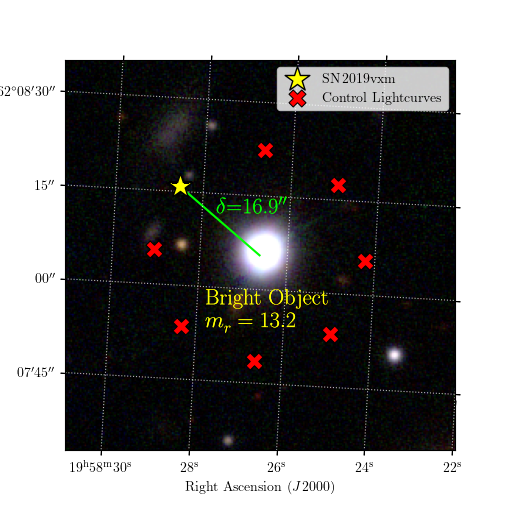

In [23]:
angles = np.linspace(0, 2*np.pi, 1001) # 317/360 * 2 * np.pi

plt.figure(figsize=[fig_width, fig_width])
axs = plt.subplot(projection=wcs)

# axs = plt.subplot()

axs.imshow(colour, origin='lower', cmap='gray')

axs.plot([x[0], x_cen], [y[0], y_cen], c='lime', zorder = 0)
axs.scatter(x[0], y[0], c='yellow', s=350, marker='*', edgecolors='k', zorder = 10, label = r'SN$\,$2019vxm')
axs.scatter(x[1:], y[1:], c='r', s=150, zorder = 1, label = 'Control Lightcurves', marker = 'X', edgecolors='k', linewidths=0.75)

axs.grid(color='w', ls='dotted', alpha = 0.7)

axs.text(x_cen-35, y_cen - 46, f'Bright Object \n $m_{{r}}^{{}} = {obj["rMeanPSFMag"].values[0]:.1f}$', 
         color='yellow', fontsize = 16, fontweight='bold', 
         path_effects=[patheffects.withStroke(linewidth=0, foreground='k')])  # Adds edgecolor to the text)
axs.text(x_cen-28, y_cen + 27, f"$\delta$={coords['radius_arcsec'].iloc[0]:.1f}$''$", 
         color='lime', fontsize = 16, fontweight='bold', 
         path_effects=[patheffects.withStroke(linewidth=0, foreground='k')])  # Adds edgecolor to the text)

axs.set_xlim(x_cen-125, x_cen+125)
axs.set_ylim(y_cen-125, y_cen+125)

axs.set_xlabel(r'Right Ascension ($J2000$)')
axs.set_ylabel(r'Declination ($J2000$)')

axs.legend()
plt.savefig('atlas_control_loc.pdf', bbox_inches='tight', format='pdf')
plt.show()